In [1]:
# make eclip object from oligoCLIP
# set up files associated with each genome coordinates
from pathlib import Path
import metadensity as md
md.settings.from_config_file('/home/hsher/projects/Metadensity/config/hg38_v35.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
figdir = '/home/hsher/scratch/oligofig/'
plt.rcParams['pdf.fonttype'] = 42

# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
import sys
sys.path.append('/home/hsher/projects/Metadensity/scripts')
from dataloader import *
%matplotlib inline

plt.style.use('seaborn-white')
from plot_params import *



please set the right config according to genome coordinate
Using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
Using:  /home/hsher/gencode_coords/gencode.v35.basic.transcript.gff3


/scratch/hsher/31446902.tscc-mgr7.local/ipykernel_1768/2979648297.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
exp_path = Path('/home/hsher/scratch/ABC_2rep')
exp_counts = exp_path/'counts'/'genome'/'tables'
exp_files = list(exp_counts.glob('*tsv.gz'))
rbps = list(set([f.name.split('.')[1] for f in exp_files]))

In [3]:
rbps

['LIN28B',
 'FAM120A',
 'EIF3G',
 'PRPF8',
 'RBFOX2',
 'ZC3H11A',
 'DDX3',
 'IGF2BP2',
 'SF3B4',
 'PUM2']

In [4]:
def highly_exp_biogps(cell_line = 'HEPG2', transcript_type = 'protein_coding', sample_no = 1000):
    ''' pre-construct metagene for highly expressed transcripts '''
    biogps = pd.read_csv('/home/hsher/projects/Metadensity_notebooks/notebooks/gene_attribute_matrix.txt', sep = '\t')
    biogps = biogps.iloc[2:]
    biogps.iloc[:, 2:] = biogps.iloc[:, 2:].astype(float, copy = False)
    
    highexp_genes = biogps.loc[biogps[cell_line]>0, '#'].tolist()
    tids = [t.attrs['transcript_id'] for t in transcript if t.attrs['transcript_type'] == transcript_type and t.attrs['gene_name'] in highexp_genes] # hungtingtin
    cds_metagenes = Build_many_metagene(tids, sample_no = sample_no)

    return cds_metagenes

In [5]:
k562_metagene = highly_exp_biogps('K562')

/scratch/hsher/31446902.tscc-mgr7.local/ipykernel_1768/1200084723.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110) have mixed types. Specify dtype option on import or set low_memory=False.
  biogps = pd.read_csv('/home/hsher/projects/Metadensity_notebooks/notebooks/gene_attribute_matrix.txt', sep = '\t')


Using: /home/hsher/projects/Metadensity/metadensity/data/hg38_v35/gencode
Done building metagene


In [6]:
def get_oligoclip_obj(exp_id, rbp, track = 'COV', exp_path = '.'):
    bw_path = exp_path /f'beta-mixture_CC/finemapping/mapped_sites/{track}'
    
    pos_bw = bw_path/f'{exp_id}.{rbp}.finemapped_windows.pos.bw'
    neg_bw = bw_path/f'{exp_id}.{rbp}.finemapped_windows.neg.bw'
    
    # placeholder
    pos_bw_bg = pos_bw
    neg_bw_bg = neg_bw
    print(pos_bw, neg_bw)
    assert pos_bw.is_file()
    assert neg_bw.is_file()
    
    
    data_series = pd.Series({'minus_0':str(neg_bw),
                  'plus_0': str(pos_bw),
                  'uid': f'{exp_id}.{rbp}.{track}',
                   'RBP':f'{rbp}({exp_id})',
                   'minus_control':str(neg_bw_bg), # place holder
                  'plus_control': str(pos_bw_bg),
                  })
    
    return eCLIP.from_series(
    data_series
    )

In [7]:
def get_clipper_obj(exp_id, rbp, exp_path = '.', track = None):
    bw_path = exp_path 
    
    pos_bw = bw_path/f'{exp_id}.{rbp}.pos.bw'
    neg_bw = bw_path/f'{exp_id}.{rbp}.neg.bw'
    
    # placeholder
    pos_bw_bg = pos_bw
    neg_bw_bg = neg_bw
    print(pos_bw, neg_bw)
    assert pos_bw.is_file()
    assert neg_bw.is_file()
    
    
    data_series = pd.Series({'minus_0':str(neg_bw),
                  'plus_0': str(pos_bw),
                  'uid': f'{exp_id}.{rbp}.clipper',
                   'RBP':f'{rbp}({exp_id}-clipper)',
                   'minus_control':str(neg_bw_bg), # place holder
                  'plus_control': str(pos_bw_bg),
                  })
    
    return eCLIP.from_series(
    data_series
    )

In [8]:
def get_metadensity(rbp, exp = 'oCLIP_Encode_Rep2_S2', track = 'COV', metagene = k562_metagene, 
                    exp_path = '.', get_oligoclip_obj = get_oligoclip_obj):
    e = get_oligoclip_obj(exp, rbp, track = track, exp_path = exp_path)
    m = Metadensity(e, e.name, metagenes = metagene.copy(), 
                    background_method = None, # peaks are supposed to be clean
                    normalize = True)
    m.get_density_array()
    return m


In [9]:
metas = [get_metadensity(rbp, exp = 'K562_rep6', 
                         exp_path = Path('/home/hsher/scratch/ABC_2rep'),
                        track = 'CITS')
         for rbp in ['PRPF8', 'SF3B4']]

/home/hsher/scratch/ABC_2rep/beta-mixture_CC/finemapping/mapped_sites/CITS/K562_rep6.PRPF8.finemapped_windows.pos.bw /home/hsher/scratch/ABC_2rep/beta-mixture_CC/finemapping/mapped_sites/CITS/K562_rep6.PRPF8.finemapped_windows.neg.bw
warning no bam file!
warning no bam file!


/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/metadensity/metadensity.py:964: RuntimeWarning: invalid value encountered in divide
  values = values/np.sum(values)
/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/metadensity/metadensity.py:1021: RuntimeWarning: Mean of empty slice
  feature_average  = np.nanmean(np.stack(all_feature_values), axis = 0)


/home/hsher/scratch/ABC_2rep/beta-mixture_CC/finemapping/mapped_sites/CITS/K562_rep6.SF3B4.finemapped_windows.pos.bw /home/hsher/scratch/ABC_2rep/beta-mixture_CC/finemapping/mapped_sites/CITS/K562_rep6.SF3B4.finemapped_windows.neg.bw
warning no bam file!
warning no bam file!


/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/metadensity/metadensity.py:964: RuntimeWarning: invalid value encountered in divide
  values = values/np.sum(values)
/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/metadensity/metadensity.py:1021: RuntimeWarning: Mean of empty slice
  feature_average  = np.nanmean(np.stack(all_feature_values), axis = 0)


In [10]:
metas_clipper = [get_metadensity(rbp, exp = 'K562_rep6', exp_path = Path('/home/hsher/scratch/clipper_bw/'),
                                get_oligoclip_obj = get_clipper_obj) for rbp in ['PRPF8', 'SF3B4']]

/home/hsher/scratch/clipper_bw/K562_rep6.PRPF8.pos.bw /home/hsher/scratch/clipper_bw/K562_rep6.PRPF8.neg.bw
warning no bam file!
warning no bam file!


/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/metadensity/metadensity.py:964: RuntimeWarning: invalid value encountered in divide
  values = values/np.sum(values)
/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/metadensity/metadensity.py:1021: RuntimeWarning: Mean of empty slice
  feature_average  = np.nanmean(np.stack(all_feature_values), axis = 0)


/home/hsher/scratch/clipper_bw/K562_rep6.SF3B4.pos.bw /home/hsher/scratch/clipper_bw/K562_rep6.SF3B4.neg.bw
warning no bam file!
warning no bam file!


/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/metadensity/metadensity.py:964: RuntimeWarning: invalid value encountered in divide
  values = values/np.sum(values)
/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/metadensity/metadensity.py:1021: RuntimeWarning: Mean of empty slice
  feature_average  = np.nanmean(np.stack(all_feature_values), axis = 0)


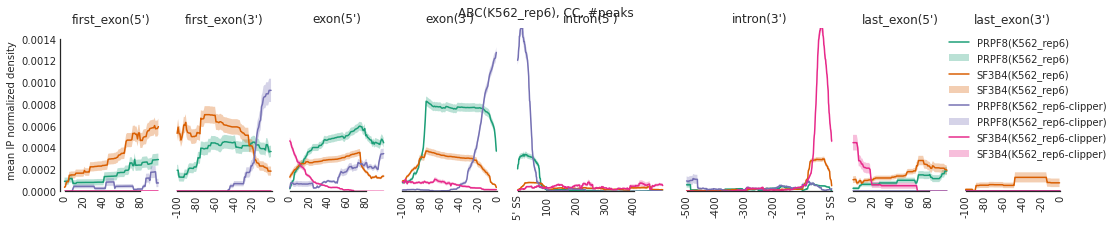

In [11]:

f=plot_mean_density([m for m in metas if 'SF3B' in m.name or 'PRPF8' in m.name]+
                    [m for m in metas_clipper if 'SF3B' in m.name or 'PRPF8' in m.name],
                    features_to_show = generic_rna,
                    ymax = 0.0015, stat = 'mean'
                   )
f=beautify(f, offset = 0)
plt.suptitle('ABC(K562_rep6), CC, #peaks')
plt.savefig(figdir/'Peak_metagene.pdf')